this notebook creates two maps that show the Hunza watershed with ESRI imagery
- first map overlays the algorithm calculated melt onset dates (MOD) for SIR pixels
- second map overlays the algorithm calculated melt onset dates (MOD) for GRD pixels

the pixel overlays are simply a scatter plot with rectangular markers and are not using EASE-grid projection

## Load in all the modules needed

In [1]:
%pylab notebook
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import pandas as pd
from cetbtools.ease2conv import Ease2Transform
from mpl_toolkits.basemap import Basemap

Populating the interactive namespace from numpy and matplotlib


In [14]:
# navigate to where scripts are saved
% cd /home/shared/Data3/cetb/jupyter_notebooks/scripts/

/mnt/data3/cetb/jupyter_notebooks/scripts


In [32]:
# load the custom functions
from CETB_read_functions import read_Tb
from CETB_read_functions import coords
from CETB_read_functions import calc_DAV
from CETB_read_functions import find_UIB_cube_offset
from CETB_read_functions import grid_locations_of_UIB
from CETB_algorithms import DAV_MOD
from CETB_analysis import MOD_array
from CETB_analysis import MOD_array_year

## Specify inputs

In [16]:
#Specify region, satellite, sensor, channel, and image reconstruction algorithm of interest in file name
# this notebook will read in 2 CETB datasets so that channels/algorithms/sensors can be compared
region='UIB'  #make this the same syntax as cubefilenames and sub-directory
sat_GRD='AQUA'   #'AQUA' for AMSRE, 'F13','F14','F15'... for SSMI
sat_SIR= 'AQUA'
sensor_GRD='AMSRE'  #'AMSRE', 'SSMI', etc.
sensor_SIR='AMSRE'
channel_GRD='36V'  #'36V','36H', '18V','18H', etc. '19V','19H' and '37V','37H' for SSMI)
channel_SIR='36V'
alg_GRD='GRD'   #SIR or GRD
alg_SIR='SIR'

if sensor_GRD=='SSMI':
    provider='CSU' 
    version='v1.2'
elif sensor_GRD=='AMSRE':
    provider='RSS'
    version='v1.3'

# either change to the directory where the data is or specify it
datadir_GRD = '/home/mij216/Desktop/data3/cetb/cubes/'+sat_GRD+'_'+sensor_GRD+'/'+region+'/' 
datadir_SIR = '/home/mij216/Desktop/data3/cetb/cubes/'+sat_SIR+'_'+sensor_SIR+'/'+region+'/' 

# prefix filepath
prefix_GRD='CETB.cubefile.'+region+'.'+sat_GRD+'_'+sensor_GRD+'-'+channel_GRD+'-'+alg_GRD+'-'+provider+'-'+version
prefix_SIR='CETB.cubefile.'+region+'.'+sat_SIR+'_'+sensor_SIR+'-'+channel_SIR+'-'+alg_SIR+'-'+provider+'-'+version

# years for each sensor
if sat_GRD=='F13' or sat_SIR=='F13':
    Years = [2002,2003,2004,2005,2006,2007,2008,2009]
elif sat_GRD=='F14' or sat_SIR=='F14':
    Years=[2002,2003,2004,2005,2006,2007,2008]
elif sat_GRD=='F15' or sat_SIR=='F15':
    Years=[2002,2003,2004,2005,2006,2007,2008,2009,2010,2011]
elif sat_GRD=='AQUA' or sat_SIR=='AQUA':
    Years=[2003,2004,2005,2006,2007,2008,2009,2010,2011]

#Enter a site name for titles of plots
Site='Hunza'

In [17]:
# SPECIFY latitude and longitude in decimal degrees, need to choose lat/lon corners so that we will load
# in a rectangle of pixels within the corners of these coordinates
lat_start=35.9
lat_end=37.1
lon_start=74
lon_end=76

In [18]:
# get cube offset for finding row/col
# function is region specific
find_UIB_cube_offset(cubeType=None, verbose=False)

(3120.000000031471, 4608.00000022618)

In [20]:
# get the GRD pixel IDs for the lat/lon rectangle chosen
rows_cols_GRD=coords(datadir_GRD, prefix_GRD, lat_start, lat_end, lon_start, lon_end)
rows_cols_GRD

(25, 33, 3, 8)

In [21]:
# row and col numbers of all the SIR pixels contained by the GRD pixels
rows_cols_env=[rows_cols_GRD[0]*8,rows_cols_GRD[1]*8, rows_cols_GRD[2]*8, rows_cols_GRD[3]*8]
rows_cols_env

[200, 264, 24, 64]

In [22]:
# load in SIR TB data
data_SIR=read_Tb(datadir_SIR, prefix_SIR, Years,rows_cols_env[0],rows_cols_env[1],rows_cols_env[2],rows_cols_env[3])
CETB_SIR=data_SIR[0]   # 3-D Tb time-series array of TB
cal_date=data_SIR[1]    # 1-D array of dates, these will get passed to later functions
cal_year=data_SIR[2]    # 1-D array of years
cal_month=data_SIR[3]   # 1-D array of months

# load GRD Tb data
data_GRD=read_Tb(datadir_GRD, prefix_GRD, Years,rows_cols_GRD[0],rows_cols_GRD[1],rows_cols_GRD[2],rows_cols_GRD[3])
CETB_GRD=data_GRD[0]

In [23]:
# calculate DAV for the Tb data that was imported
DAV_SIR=calc_DAV(CETB_SIR)
DAV_GRD=calc_DAV(CETB_GRD)

## get the latitudes and longitudes of each pixel for plotting

In [24]:
#Get lat/lon of each pixel in the subset of 64
# these get used for plotting over basemap
filename=datadir_SIR+prefix_SIR+'.'+str(2003)+'.TB.nc'	
data=Dataset(filename, "r", format="NETCDF4")

lat=data.variables['latitude'] 
lat=lat[:]
lon=data.variables['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

coordinates=lat_lon[rows_cols_env[0]:rows_cols_env[1],rows_cols_env[2]:rows_cols_env[3]]

coordinates=coordinates.reshape(((rows_cols_env[1]-rows_cols_env[0])*(rows_cols_env[3]-rows_cols_env[2])),2)
pixel_lats=coordinates[:,0]
pixel_lons=coordinates[:,1]

pixel_lats

array([37.51086985, 37.48042702, 37.44997903, ..., 35.87361555,
       35.84317362, 35.81272617])

In [25]:
#Get lat/lon for GRD pixels
# similar to SIR above
filename=datadir_GRD+prefix_GRD+'.'+str(2003)+'.TB.nc'	
data=Dataset(filename, "r", format="NETCDF4")

lat=data.variables['latitude'] 
lat=lat[:]
lon=data.variables['longitude']
lon=lon[:]
lat_lon=np.dstack((lat,lon))

coordinates=lat_lon[rows_cols_GRD[0]:rows_cols_GRD[1],rows_cols_GRD[2]:rows_cols_GRD[3]]

coordinates=coordinates.reshape(((rows_cols_GRD[1]-rows_cols_GRD[0])*(rows_cols_GRD[3]-rows_cols_GRD[2])),2)
pixel_lats_GRD=coordinates[:,0]
pixel_lons_GRD=coordinates[:,1]

pixel_lats_GRD

array([37.37745373, 37.13370658, 36.8896261 , 36.64521097, 36.40045984,
       37.31533536, 37.07178516, 36.82789953, 36.58367717, 36.33911674,
       37.2521595 , 37.008809  , 36.76512093, 36.52109401, 36.27672694,
       37.18792871, 36.94478059, 36.70129274, 36.45746392, 36.21329284,
       37.12264554, 36.87970245, 36.63641747, 36.39278935, 36.14881684,
       37.05631258, 36.81357715, 36.57049763, 36.32707279, 36.08330139,
       36.98893244, 36.74640726, 36.50353575, 36.26031672, 36.01674895,
       36.92050778, 36.67819538, 36.43553441, 36.19252369, 35.94916202])

## create arrays of MOD to be used for plotting

In [26]:
# get array of average MODs for SIR pixels for all the years loaded
window=10   # window for MOD algorithm, '10' would be 5 days (2 measurements per day)
count=3    # number of Tb/DAV exceedances to trigger MOD
DAV_threshold=40
Tb_threshold=252

# sir MOD array - MOD will be in day of year (DOY)
MOD_DOY_array=MOD_array(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array

masked_array(data=[75.25, 53.625, 60.125, ..., nan, nan, 119.6],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [27]:
# get array of MOD for each pixel SIR - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
year=2003


MOD_DOY_array_year=MOD_array_year(datadir_SIR, prefix_SIR, CETB_SIR, DAV_SIR, rows_cols_env, cal_date, year, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_year

masked_array(data=[99.0, 83.0, 131.0, ..., nan, nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [28]:
# MOD of the GRD pixel - avg all years
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252

MOD_DOY_array_GRD=MOD_array(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, Years, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_GRD

masked_array(data=[113.5, nan, nan, nan, nan, 108.25, 107.75, 115.0,
                   123.44444444444444, 140.625, 114.0, 116.375,
                   122.22222222222223, 115.55555555555556, 131.75,
                   112.77777777777777, 114.22222222222223,
                   118.88888888888889, 150.0, 196.66666666666666,
                   113.77777777777777, 109.77777777777777, 126.0, nan,
                   147.66666666666666, 120.33333333333333, 120.5, nan,
                   nan, nan, 117.66666666666667, 120.66666666666667,
                   130.83333333333334, nan, 137.0, 118.44444444444444,
                   130.88888888888889, 124.88888888888889, nan, nan],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   Fals

In [29]:
# get MOD for GRD pixel - one year of interest
#window=10
#count=3
#DAV_threshold=18
#Tb_threshold=252
#year=2003
MOD_DOY_array_GRD_year=MOD_array_year(datadir_GRD, prefix_GRD, CETB_GRD, DAV_GRD, rows_cols_GRD, cal_date, year, window, count, DAV_threshold, Tb_threshold)
MOD_DOY_array_GRD_year

masked_array(data=[nan, nan, nan, nan, nan, nan, 131.0, 131.0, 142.0,
                   145.0, nan, 140.0, 142.0, 131.0, 140.0, 136.0, 138.0,
                   140.0, 152.0, 182.0, 129.0, 129.0, 152.0, nan, 154.0,
                   140.0, 138.0, nan, nan, nan, 129.0, 129.0, 140.0, nan,
                   nan, 127.0, 140.0, 131.0, nan, nan],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False],
       fill_value=1e+20)

## create the maps

<IPython.core.display.Javascript object>


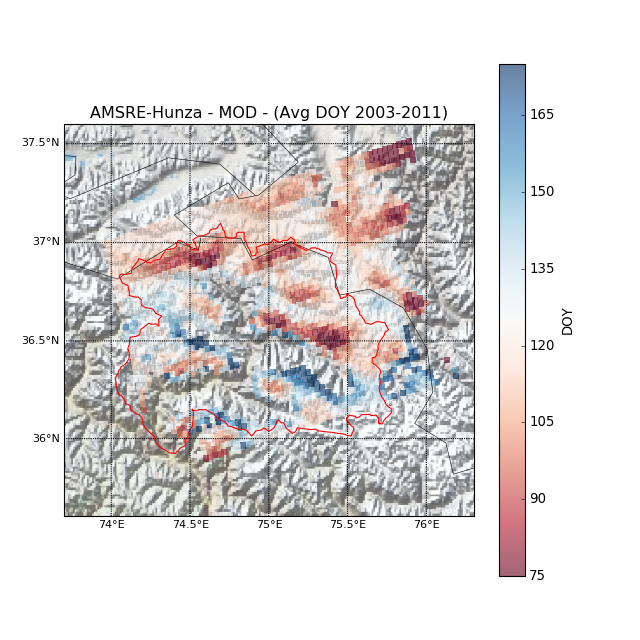

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=8204246.471464263,4245720.660441586,8493677.147526773,4523072.31910875&bboxSR=3857&imageSR=3857&size=1500,1437&dpi=96&format=png32&f=image


<IPython.core.display.Javascript object>


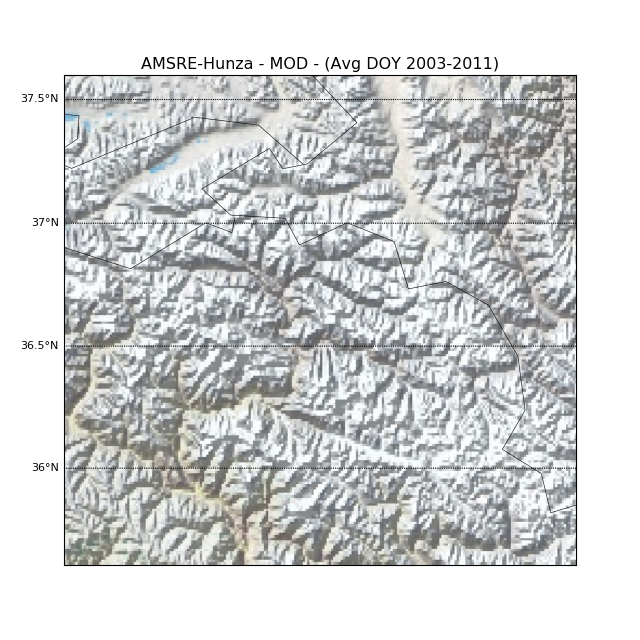

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=8204246.471464263,4245720.660441586,8493677.147526773,4523072.31910875&bboxSR=3857&imageSR=3857&size=1500,1437&dpi=96&format=png32&f=image


In [30]:
# PLOT the MOD MAP - avg of all years or one year of interest - SIR

# Choose plot type - 'year' for one year of interest, 'all' for average of all years
#plot_type='year'  
plot_type='all'

#year=2003


if plot_type=='all':
    array=MOD_DOY_array
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)

x,y=m(pixel_lons, pixel_lats)
m.scatter(x,y,c=array, s=30, marker='s',lw=0,cmap='RdBu', alpha=.6)
plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)


plt.title(title)
plt.show()


<IPython.core.display.Javascript object>


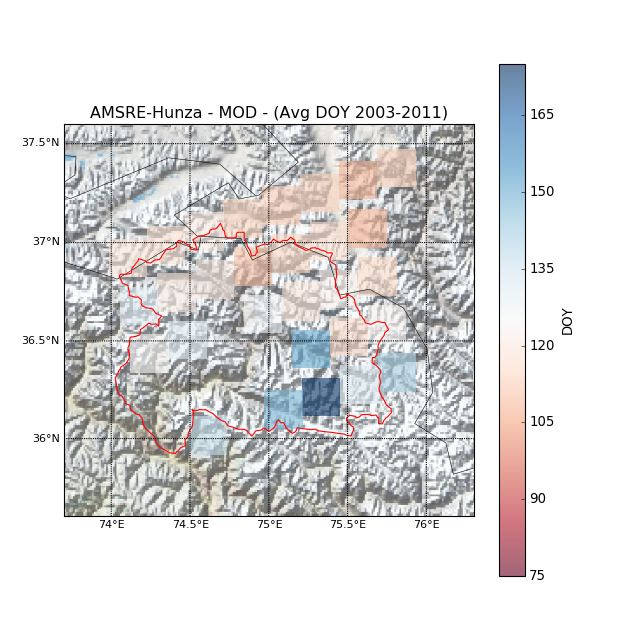

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=8204246.471464263,4245720.660441586,8493677.147526773,4523072.31910875&bboxSR=3857&imageSR=3857&size=1500,1437&dpi=96&format=png32&f=image


<IPython.core.display.Javascript object>


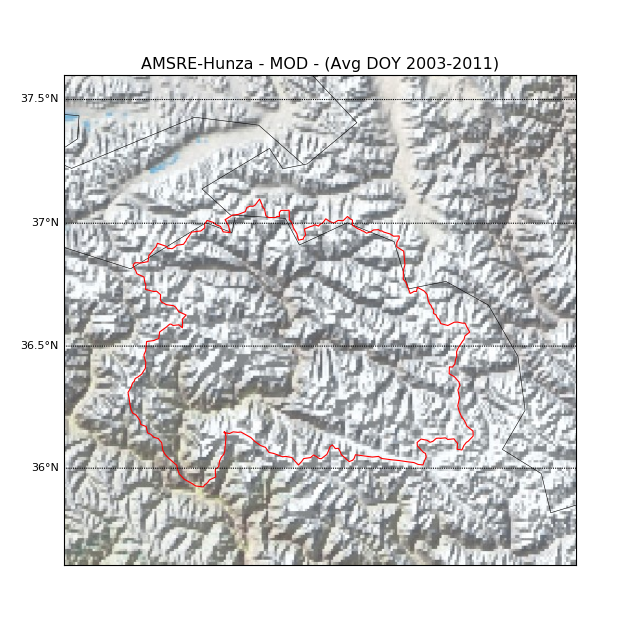

http://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/export?bbox=8204246.471464263,4245720.660441586,8493677.147526773,4523072.31910875&bboxSR=3857&imageSR=3857&size=1500,1437&dpi=96&format=png32&f=image


In [31]:
# PLOT the MOD MAP - avg of all years or one year of interest - GRD
# Choose plot type - 'year' for one year of interest, 'all' for average of all years
#plot_type='year'  
plot_type='all'

#year=2003


if plot_type=='all':
    array=MOD_DOY_array_GRD
    title=sensor_SIR+'-'+Site+' - MOD - (Avg DOY '+str(Years[0])+'-'+str(Years[-1])+')'
elif plot_type=='year':
    array=MOD_DOY_array_GRD_year
    title=sensor_SIR+'-'+Site+' - MOD - ('+str(year)+' DOY)'

fig = plt.figure(figsize=(8,8))
# create figure and axes instances
#fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
#ax = fig.add_subplot(121)
# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
#m.etopo(scale=3, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(0,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)

m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)

x,y=m(pixel_lons_GRD, pixel_lats_GRD)
m.scatter(x,y,c=array, s=1200, marker='s',lw=0,cmap='RdBu', alpha=.6)

plt.title(title)

plt.colorbar(label='DOY')
plt.clim(75,175)  #color bar limits

plt.show()


# plot another blank map with no pixel overlay
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# create polar stereographic Basemap instance.
m = Basemap(projection='stere',lon_0=(lon_start+lon_end)/2,lat_0=(lat_start+lat_end)/2,lat_ts=90.,\
            llcrnrlat=(lat_start-.3),urcrnrlat=(lat_end+.5),\
            llcrnrlon=(lon_start-.3),urcrnrlon=(lon_end+.3),\
            rsphere=6371200.,resolution='l',area_thresh=10000, epsg=3857)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
#m.etopo(scale=5, alpha=0.7)
#m.bluemarble(scale=1)
parallels = np.arange(0.,90,0.5)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,0.5)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
m.arcgisimage(service='World_Physical_Map', xpixels = 1500, verbose= True)
m.readshapefile('/home/mij216/ExploringCETB/IN_Hunza_at_DainyorBridge', 'Hunza', color='red', linewidth=1)

plt.title(title)
plt.show()